<a href="https://colab.research.google.com/github/SAMAWELJABALLI/TweetsSentimentAnalysis/blob/main/SVM_classifier_Tunisian_Dialect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **THE SUPPORT VECTOR MACHINE (SVM) MODEL ON TUNISIAN DIALECT**

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report,roc_curve, auc, accuracy_score

from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import re
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.svm import SVC
import seaborn as sns
from tqdm import tqdm
import os

In [13]:
# Load data and set labels from corpus 1 
df = pd.read_csv('/content/data_clean.csv', lineterminator='\n')
print(f'Shape of data is {df.shape}')
# Display 20 random samples
df.drop(columns=["text", "message_len"],inplace=True)
df.sample(20)

Shape of data is (199097, 6)


,Unnamed: 0,ID,label,text_clean
21147,21147,21147,1,يجب اعلان حجر التجول بالكامل و الا ستحصل الكارثة
62570,63571,13680,0,أسوء شركة تسوق اونلاين حراميه مصاريف الشحن الد...
127104,131658,22359,1,اشمادخل عبير ماعملت شي كان السرقة والنهبة لفلو...
191522,198243,62126,1,w w
131875,136440,323,0,atrma lhnina
35276,35276,35276,1,ستار ربي
52357,52560,2669,1,تطبيق عبقرى
69249,70827,20936,0,stealers
110396,114950,5651,1,tabbabi wafa
123197,127751,18452,1,ياربي اسطرن


# Loading saved vectors 


In [14]:
# loading bow vectors
X_train_bow = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("/content/drive/MyDrive/saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("/content/drive/MyDrive/saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("/content/drive/MyDrive/saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))

'''#tfidf-w2v
X_train_tfw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))

'''
y_train = np.load('/content/drive/MyDrive/saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('/content/drive/MyDrive/saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (139367, 144497)
shape of X_test_bow is (59730, 144497)
shape of X_train_tfidf is (139367, 144497)
shape of X_test_tfidf is (59730, 144497)
shape of X_train_avgw2v is (139367, 50)
shape of X_test_avgw2v is (59730, 50)
shape of y_train is (139367,)
shape of y_test is (59730,)


# helper function to plot confusion matrix

In [18]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()

# **Linear SVM**

## Linear SVM On Bow
We will use SGD classifier here. It is similar to Linear SVM with SGD implementation.



Model with best parameters :
 {'alpha': 0.0001, 'penalty': 'l2'}


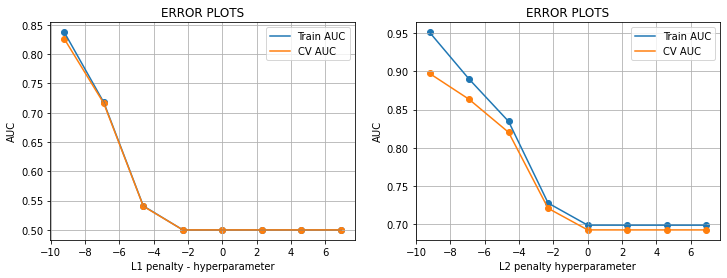

In [16]:
%%time
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(X_train_bow,y_train)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
  axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(Alpha), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(Alpha), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

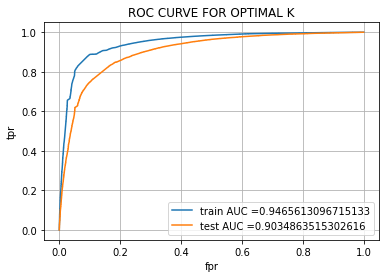

Area under train roc 0.9465613096715133
Area under test roc 0.9034863515302616


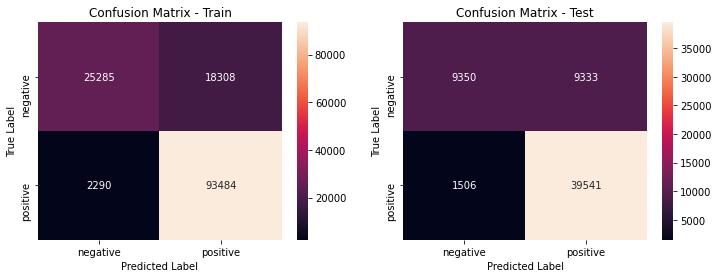


-----classification report on train data on BagOfwords Features-----

              precision    recall  f1-score   support

           0       0.92      0.58      0.71     43593
           1       0.84      0.98      0.90     95774

    accuracy                           0.85    139367
   macro avg       0.88      0.78      0.81    139367
weighted avg       0.86      0.85      0.84    139367


-----classification report on validation data on BagOfwords Features-----

              precision    recall  f1-score   support

           0       0.86      0.50      0.63     18683
           1       0.81      0.96      0.88     41047

    accuracy                           0.82     59730
   macro avg       0.84      0.73      0.76     59730
weighted avg       0.83      0.82      0.80     59730



In [17]:
svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(X_train_bow,y_train)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt,X_train_bow,y_train,X_test_bow,y_test)

#classification report on train data
print('\n-----classification report on train data on BagOfwords Features-----\n')
print(classification_report(y_train, svm_opt.predict(X_train_bow)))

#classification report on validation data
print('\n-----classification report on validation data on BagOfwords Features-----\n')
print(classification_report(y_test, svm_opt.predict(X_test_bow)))

**Why use CaliberatedCV?**

SVM by default cannot gives the probability of target variables. So we use CaliberatedCV to get it as it is used for calculation of our metrics(AUC)

# **Feature importance**

In [18]:
data_l2 = svm_opt.coef_.reshape(-1,1)

datafr_l2 = pd.DataFrame(data_l2,columns=['coef'],index=bow_features)
#Top 10 negative features
negative = datafr_l2.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l2.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                 coef
maset      -1.837847
masta      -1.833365
tfouh      -1.824400
arnaque    -1.806469
ماسط       -1.801987
nul        -1.797504
mauvaise   -1.770609
mamstou    -1.766126
mauvais    -1.734748
arnaqueurs -1.703371
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
             coef
bravo   1.385109
wahra   1.017540
ممتاز   0.950301
sakrou  0.892028
jaw     0.838238
bonne   0.779964
masque  0.721691
برافو   0.721691
tbib    0.712726
رائع    0.708244


# Linear SVM on TFIDF features

Model with best parameters :
 {'alpha': 0.0001, 'penalty': 'l2'}


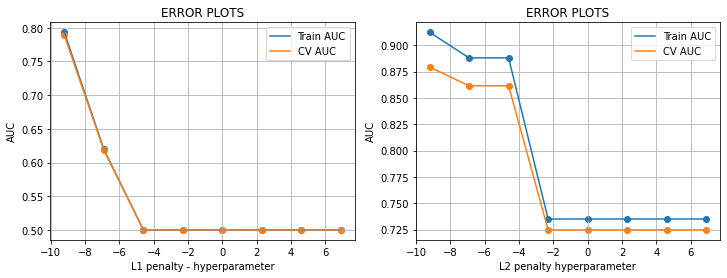

CPU times: user 1.51 s, sys: 286 ms, total: 1.79 s
Wall time: 24.2 s


In [21]:
%%time
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(X_train_tfidf,y_train)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
  axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(Alpha), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(Alpha), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

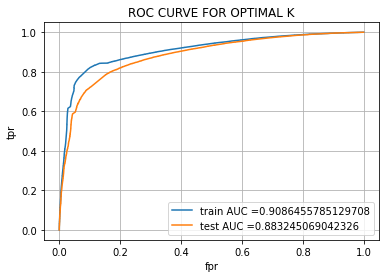

Area under train roc 0.9086455785129708
Area under test roc 0.883245069042326


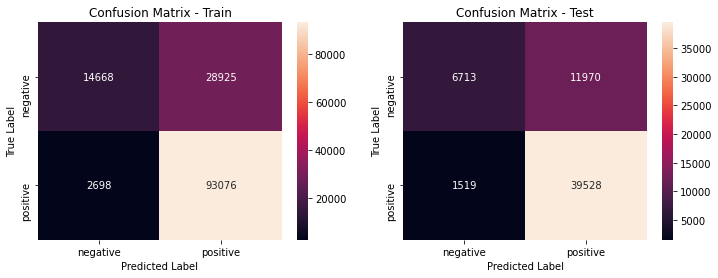


-----classification report on train data on TFIDF Features-----

              precision    recall  f1-score   support

           0       0.84      0.34      0.48     43593
           1       0.76      0.97      0.85     95774

    accuracy                           0.77    139367
   macro avg       0.80      0.65      0.67    139367
weighted avg       0.79      0.77      0.74    139367


-----classification report on validation data on TFIDF Features-----

              precision    recall  f1-score   support

           0       0.82      0.36      0.50     18683
           1       0.77      0.96      0.85     41047

    accuracy                           0.77     59730
   macro avg       0.79      0.66      0.68     59730
weighted avg       0.78      0.77      0.74     59730



In [22]:
svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(X_train_tfidf,y_train)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt,X_train_tfidf,y_train,X_test_tfidf,y_test)

#classification report on train data
print('\n-----classification report on train data on TFIDF Features-----\n')
print(classification_report(y_train, svm_opt.predict(X_train_tfidf)))

#classification report on validation data
print('\n-----classification report on validation data on TFIDF Features-----\n')
print(classification_report(y_test, svm_opt.predict(X_test_tfidf)))

# **Feature importance**

In [23]:
data_l2 = svm_opt.coef_.reshape(-1,1)

datafr_l2 = pd.DataFrame(data_l2,columns=['coef'],index=tfidf_features)
#Top 10 negative features
negative = datafr_l2.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l2.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
           coef
لا   -4.688776
ti   -3.337630
bara -3.277943
nul  -3.116554
ken  -3.095168
ki   -3.031938
mala -3.025583
ماسط -3.000354
fih  -2.958667
pas  -2.950684
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
              coef
bravo    2.861233
bonne    1.826589
rabi     1.657720
mabrouk  1.413211
slouma   1.384063
merci    1.373070
bien     1.225636
sakrou   1.213741
rabbi    1.120599
bon      1.094868


# Linear SVM on Average Word2Vec


Model with best parameters :
 {'alpha': 0.001, 'penalty': 'l2'}


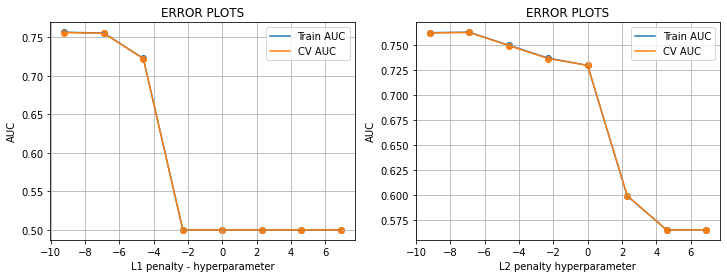

In [24]:
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(X_train_avgw2v, y_train)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
  axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(Alpha), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(Alpha), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

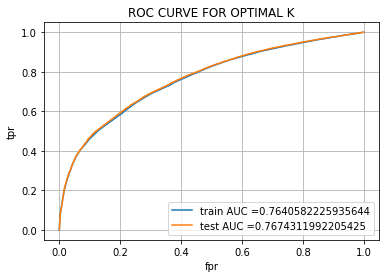

Area under train roc 0.7640582225935644
Area under test roc 0.7674311992205425


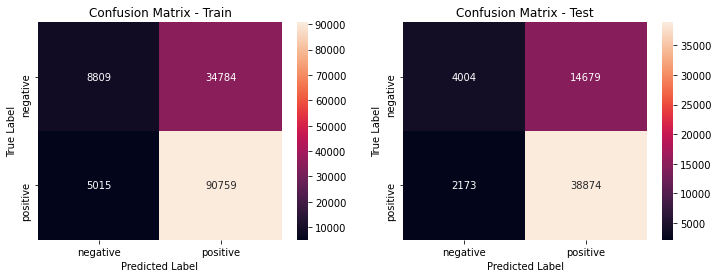


-----classification report on train data on Averge word2vec -----

              precision    recall  f1-score   support

           0       0.64      0.20      0.31     43593
           1       0.72      0.95      0.82     95774

    accuracy                           0.71    139367
   macro avg       0.68      0.57      0.56    139367
weighted avg       0.70      0.71      0.66    139367


-----classification report on validation data on Averge word2vec -----

              precision    recall  f1-score   support

           0       0.65      0.21      0.32     18683
           1       0.73      0.95      0.82     41047

    accuracy                           0.72     59730
   macro avg       0.69      0.58      0.57     59730
weighted avg       0.70      0.72      0.67     59730



In [25]:
svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(X_train_avgw2v,y_train)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_avgw2v,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt,X_train_avgw2v,y_train,X_test_avgw2v,y_test)


#classification report on train data
print('\n-----classification report on train data on Averge word2vec -----\n')
print(classification_report(y_train, svm_opt.predict(X_train_avgw2v)))

#classification report on validation data
print('\n-----classification report on validation data on Averge word2vec -----\n')
print(classification_report(y_test, svm_opt.predict(X_test_avgw2v)))

# **SVM RBF Kernel Classifier**
Note: RBF kernel SVM is very computationaly expensive.So we will try with 20k datapoints

In [5]:
# Load data and set labels from corpus 1 
df = pd.read_csv('/content/data_clean.csv', lineterminator='\n')
print(f'Shape of data is {df.shape}')
# Display 20 random samples
df.drop(columns=["text", "message_len"],inplace=True)
df2 = df.sample(20000,random_state=100)
print(f'Shape of data is {df2.shape}')


Shape of data is (199097, 6)
Shape of data is (20000, 4)


In [8]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = df2['text_clean']
y = df2['label']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)

# SVM RBF On BOW


In [14]:
bow = CountVectorizer(min_df=10,max_features=500)
bow.fit(X_train.astype('U'))
X_train_bow = bow.transform(X_train.astype('U'))
X_test_bow = bow.transform(X_test.astype('U'))
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (14000, 500)
shape of X_test_bow is (6000, 500)


Model with best parameters :
 {'C': 10, 'gamma': 0.01}


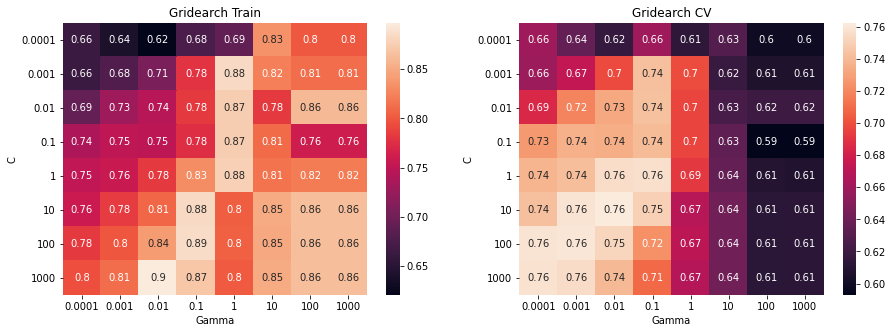

CPU times: user 22.5 s, sys: 1.99 s, total: 24.5 s
Wall time: 48min 46s


In [16]:
%%time 
from sklearn.svm import SVC
c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':c,'gamma': Gamma}
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5,return_train_score=True)
model.fit(X_train_bow,y_train)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(8,8)
cv_auc = model.cv_results_['mean_test_score'].reshape(8,8)
f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=Gamma,yticklabels=c,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("Gamma")
  axes[i].set_ylabel("C")


plt.show() 

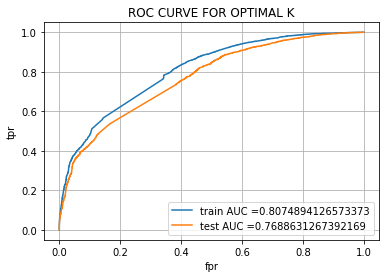

Area under train roc 0.8074894126573373
Area under test roc 0.7688631267392169


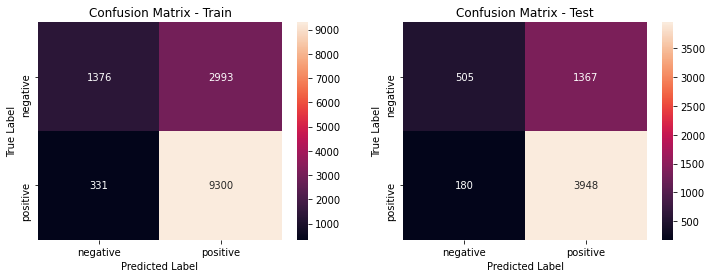


-----classification report on train data on BOW features-----

              precision    recall  f1-score   support

           0       0.81      0.31      0.45      4369
           1       0.76      0.97      0.85      9631

    accuracy                           0.76     14000
   macro avg       0.78      0.64      0.65     14000
weighted avg       0.77      0.76      0.72     14000


-----classification report on validation data on BOW features-----

              precision    recall  f1-score   support

           0       0.74      0.27      0.39      1872
           1       0.74      0.96      0.84      4128

    accuracy                           0.74      6000
   macro avg       0.74      0.61      0.62      6000
weighted avg       0.74      0.74      0.70      6000



In [19]:
best_est = SVC(**model.best_params_,probability=True)
best_est = best_est.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_bow,y_train,X_test_bow,y_test)

#classification report on train data
print('\n-----classification report on train data on BOW features-----\n')
print(classification_report(y_train, model.predict(X_train_bow)))

#classification report on validation data
print('\n-----classification report on validation data on BOW features-----\n')
print(classification_report(y_test, model.predict(X_test_bow)))

# SVM RBF On TFIDF


In [20]:
#applying tfidf on x_train and x_test
vectorizer = TfidfVectorizer(min_df=10,max_features=500)
vectorizer.fit(X_train.astype('U'))
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train.astype('U'))
X_test_tfidf = vectorizer.transform(X_test.astype('U'))

print('shape of X_train_tfidf is {}'.format(X_train_tfidf.get_shape()))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.get_shape()))

shape of X_train_tfidf is (14000, 500)
shape of X_test_tfidf is (6000, 500)


Model with best parameters :
 {'C': 1000, 'gamma': 0.001}


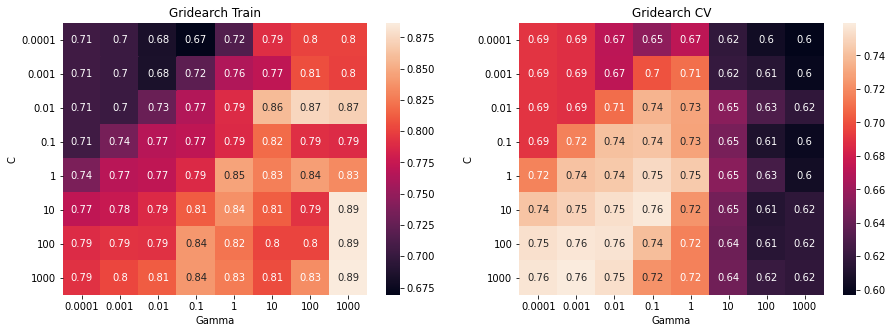

CPU times: user 15.3 s, sys: 852 ms, total: 16.2 s
Wall time: 18min 47s


In [21]:
%%time
from sklearn.svm import SVC
c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':c,'gamma': Gamma}
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3,return_train_score=True)
model.fit(X_train_tfidf,y_train)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(8,8)
cv_auc = model.cv_results_['mean_test_score'].reshape(8,8)
f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=Gamma,yticklabels=c,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("Gamma")
  axes[i].set_ylabel("C")

plt.show()


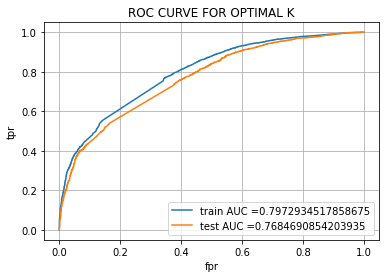

Area under train roc 0.7972934517858675
Area under test roc 0.7684690854203935


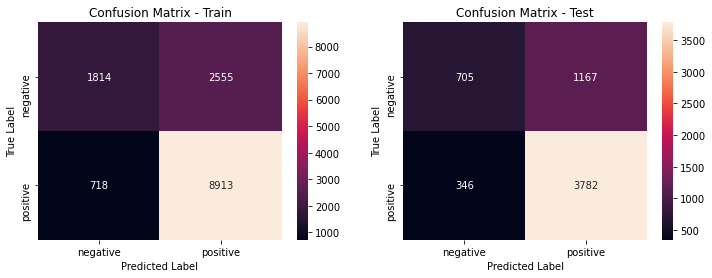


-----classification report on train data on TFIDF features-----

              precision    recall  f1-score   support

           0       0.72      0.42      0.53      4369
           1       0.78      0.93      0.84      9631

    accuracy                           0.77     14000
   macro avg       0.75      0.67      0.69     14000
weighted avg       0.76      0.77      0.75     14000


-----classification report on validation data on TFIDF features-----

              precision    recall  f1-score   support

           0       0.67      0.38      0.48      1872
           1       0.76      0.92      0.83      4128

    accuracy                           0.75      6000
   macro avg       0.72      0.65      0.66      6000
weighted avg       0.74      0.75      0.72      6000



In [22]:
from sklearn.svm import SVC
best_est = SVC(**model.best_params_,probability=True)
best_est = best_est.fit(X_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_tfidf,y_train,X_test_tfidf,y_test)

#classification report on train data
print('\n-----classification report on train data on TFIDF features-----\n')
print(classification_report(y_train, model.predict(X_train_tfidf)))

#classification report on validation data
print('\n-----classification report on validation data on TFIDF features-----\n')
print(classification_report(y_test, model.predict(X_test_tfidf)))

# SVM RGBF ON AVERGE WORD2VEC

In [33]:
# Train your own Word2Vec model using your own text corpus
preprocessed_reviews = X_train.values.astype('U')

train_sentance=[]
for sentance in preprocessed_reviews:
    train_sentance.append(sentance.split())

want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(train_sentance,min_count=5,size=50, workers=4)

w2v_words_train = list(w2v_model_train.wv.vocab)
#################################################################################
# compute average word2vec for each review for train data.
preprocessed_reviews = X_train.values.astype('U')
list_of_sentancetrain = []
for sentance in preprocessed_reviews:
    list_of_sentancetrain.append(sentance.split())


sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetrain): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

###########################################################


# compute average word2vec for each review for test data.
preprocessed_reviews = X_test.values.astype('U')
list_of_sentancetest = []
for sentance in preprocessed_reviews:
    list_of_sentancetest.append(sentance.split())

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetest): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

X_train_avgw2v = sent_vectors_train
X_test_avgw2v = sent_vectors_test

  6%|▋         | 387/6000 [00:00<00:01, 3843.54it/s]

14000
50


100%|██████████| 6000/6000 [00:01<00:00, 3200.47it/s]

6000
50


Model with best parameters :
 {'C': 1000, 'gamma': 1}


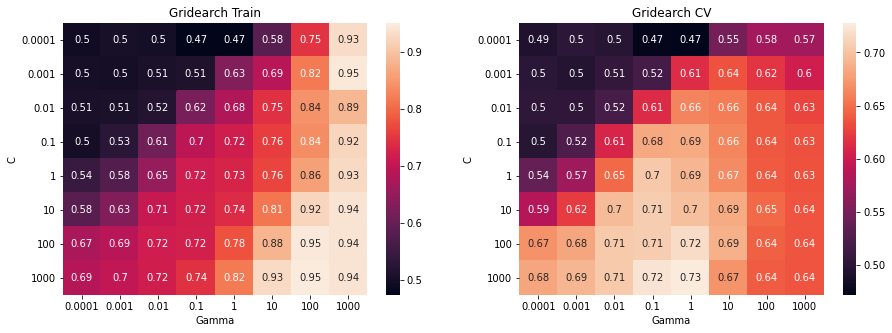

In [34]:
from sklearn.svm import SVC
c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':c,'gamma': Gamma}
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3,return_train_score=True)
model.fit(X_train_avgw2v,y_train)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(8,8)
cv_auc = model.cv_results_['mean_test_score'].reshape(8,8)
f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=Gamma,yticklabels=c,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("Gamma")
  axes[i].set_ylabel("C")


plt.show()

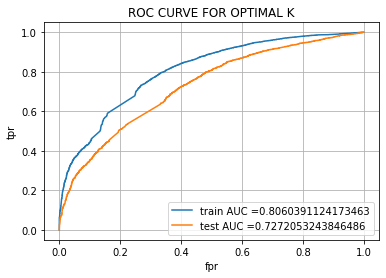

Area under train roc 0.8060391124173463
Area under test roc 0.7272053243846486


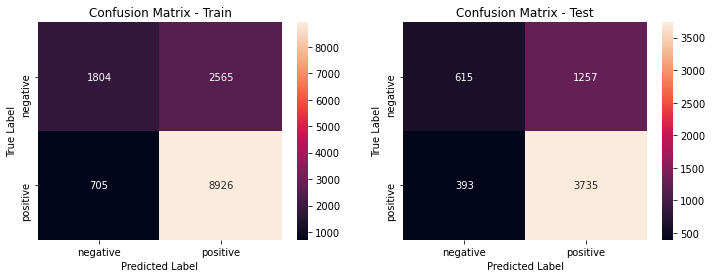


-----classification report on train data on Averge Word2VEC features -----

              precision    recall  f1-score   support

           0       0.72      0.41      0.52      4369
           1       0.78      0.93      0.85      9631

    accuracy                           0.77     14000
   macro avg       0.75      0.67      0.68     14000
weighted avg       0.76      0.77      0.75     14000


-----classification report on validation data on Averge Word2VEC features-----

              precision    recall  f1-score   support

           0       0.61      0.33      0.43      1872
           1       0.75      0.90      0.82      4128

    accuracy                           0.73      6000
   macro avg       0.68      0.62      0.62      6000
weighted avg       0.71      0.72      0.70      6000



In [35]:
best_est = SVC(**model.best_params_,probability=True)
best_est = best_est.fit(X_train_avgw2v,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

plot_confusion_matrixes(best_est,X_train_avgw2v,y_train,X_test_avgw2v,y_test)


#classification report on train data
print('\n-----classification report on train data on Averge Word2VEC features -----\n')
print(classification_report(y_train, model.predict(X_train_avgw2v)))

#classification report on validation data
print('\n-----classification report on validation data on Averge Word2VEC features-----\n')
print(classification_report(y_test, model.predict(X_test_avgw2v)))

# **Observations and Conclusions**



In [37]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","kernel","penalty","Hyperparam-alpha","Hyperparam-C","gamma","Train AUC", "Test AUC","Train accuracy", "Test accuracy"]

z.add_row(["bow","SVM","linear","l2",0.0001,"-","-",0.9465613096715133,0.9034863515302616,0.85,0.82])
z.add_row(["tfidf","SVM","linear","l2",0.0001,"-","-",0.9086455785129708,0.883245069042326,0.77,0.77])
z.add_row(["avg-w2v","SVM","linear","l2",0.001,"-","-",0.7640582225935644,0.7674311992205425,0.71,0.72])
#z.add_row(["tfidf-w2v","SVM","linear","l2",0.001,"-","-",0.8840266485280304,0.8828121426206832])
z.add_row(["bow","SVM","RBF","-","-",10,0.01,0.8074894126573373,0.7688631267392169,0.76,0.74])
z.add_row(["tfidf","SVM","RBF","-","-",100,0.001,0.7972934517858675,0.7684690854203935,0.77,0.75])
z.add_row(["avg-w2v","SVM","RBF","-","-",1000,1,0.8060391124173463,0.7272053243846486,0.77,0.73])
#z.add_row(["tfidf-w2v","SVM","RBF","-","-",1000,0.01,0.8979185918936899,0.8832558625135044])
print(z)


+---------+-----------+--------+---------+------------------+--------------+-------+--------------------+--------------------+----------------+---------------+
|  Vector | Algorithm | kernel | penalty | Hyperparam-alpha | Hyperparam-C | gamma |     Train AUC      |      Test AUC      | Train accuracy | Test accuracy |
+---------+-----------+--------+---------+------------------+--------------+-------+--------------------+--------------------+----------------+---------------+
|   bow   |    SVM    | linear |    l2   |      0.0001      |      -       |   -   | 0.9465613096715133 | 0.9034863515302616 |      0.85      |      0.82     |
|  tfidf  |    SVM    | linear |    l2   |      0.0001      |      -       |   -   | 0.9086455785129708 | 0.883245069042326  |      0.77      |      0.77     |
| avg-w2v |    SVM    | linear |    l2   |      0.001       |      -       |   -   | 0.7640582225935644 | 0.7674311992205425 |      0.71      |      0.72     |
|   bow   |    SVM    |  RBF   |    -   


* SVM performs good with our text data.
* Some of the linear SVM models are slightly overfitting.
* As RBF kernels are computationally expensive we only used 20000 points Eventhen the model is performing well. Eventhough our RBF based models are 
overfitting, it can be overcome by using more train data.
* Here out of all our model we have a more generalized model with linear SVM on average word2vec vectors.